# Pix2Pix GAN to generate maps from satellite imagery 

#### In this project, we explore the power of Generative Adversarial Networks (GANs) to perform image-to-image translation, a task often referred to as "Pix2Pix." GANs have revolutionized the field of computer vision and image processing by enabling us to generate realistic images from input data. Pix2Pix, a specific GAN variant, excels at transforming images from one domain to another, making it an exciting tool for various applications.

#### Image-to-image translation is a fascinating challenge in the realm of computer vision. It involves converting an image from one style, domain, or representation to another. For instance, we can transform black-and-white sketches into colorful images, turn satellite images into maps, or change summer photos into winter scenes. Pix2Pix GANs have shown remarkable capabilities in solving these problems by learning the mapping between input and output domains.
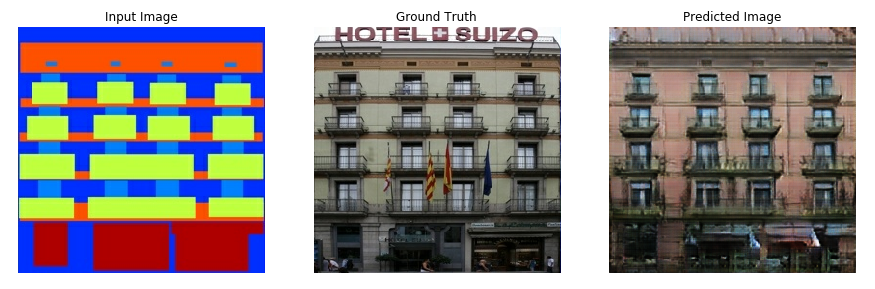

#### Pix2Pix consists of two neural networks: a generator and a discriminator. The generator takes an input image from one domain and tries to produce an output image in the desired target domain. Simultaneously, the discriminator evaluates whether the generated image is realistic or not. Through adversarial training, the generator learns to improve its output, making it increasingly difficult for the discriminator to distinguish between real and generated images.
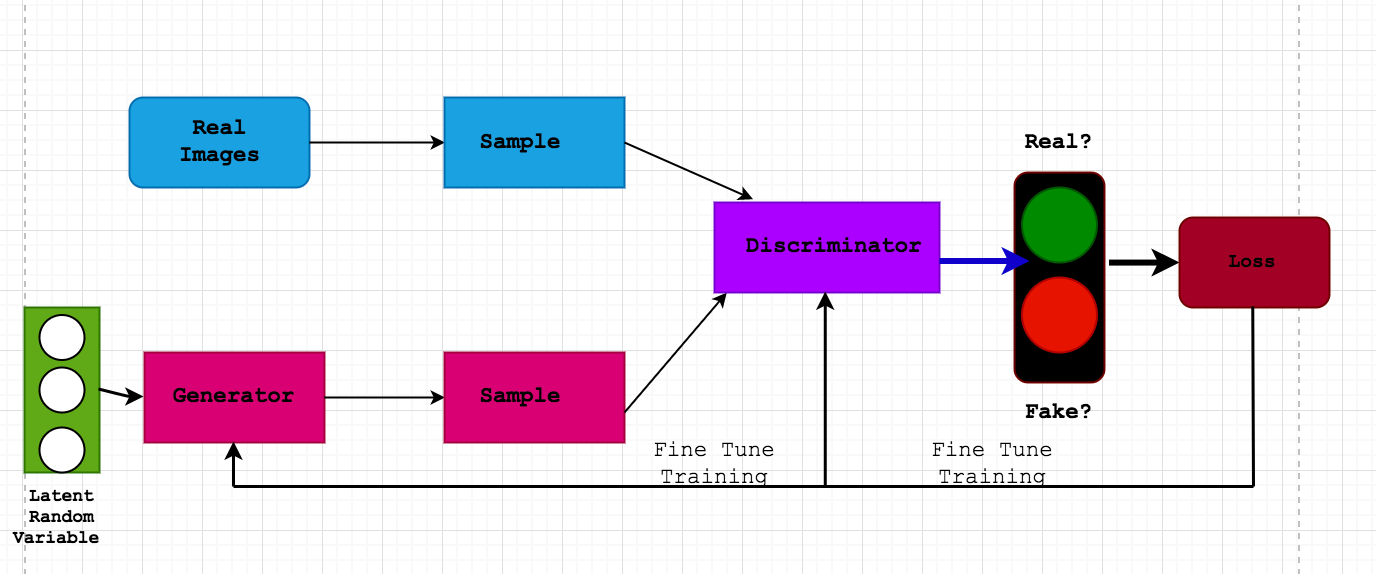

## Impoting relevant libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import time

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Conv2D, Input, MaxPool2D, Conv2DTranspose, concatenate, Lambda, BatchNormalization, Activation, LeakyReLU, ReLU
from keras.utils import img_to_array, load_img, plot_model
from keras.optimizers import Adam
from keras.initializers import RandomNormal

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Reading the data, and seeing the training images

#### The dataset contains satellite images along with the annotated images that look like a map version of our satellite image. The satellite and the target images are both given in one single image side by side.

In [2]:
path = "../input/pix2pix-dataset/maps/maps/train/"
num_images = 1000

combined_images = sorted(glob(path + "*.jpg"))[:num_images]
    
images = np.zeros(shape=(len(combined_images), 256, 256, 3))
masks = np.zeros(shape=(len(combined_images), 256, 256, 3))

for idx, path in enumerate(combined_images):

    combined_image = tf.cast(img_to_array(load_img(path)), tf.float32)
    
    image = combined_image[:,:600,:]
    mask = combined_image[:,600:,:]

    images[idx] = (tf.image.resize(image,(256,256)))/255
    masks[idx] = (tf.image.resize(mask,(256,256)))/255


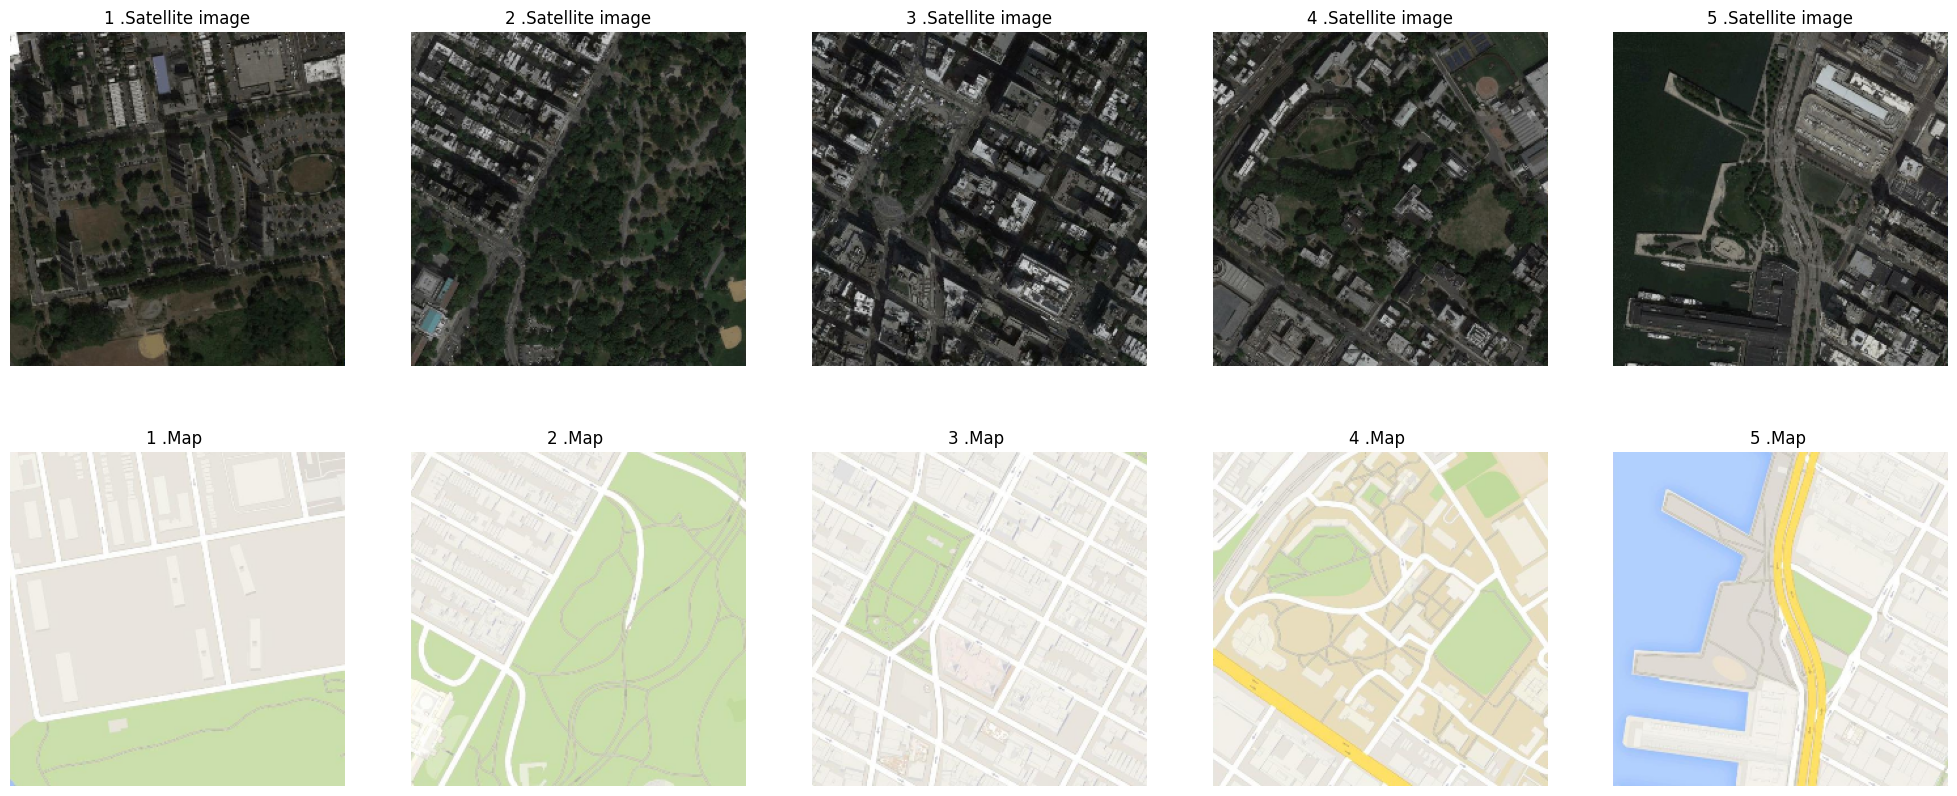

In [3]:
plt.figure(figsize=(25,10))
for i in range(1,6):
    idx = np.random.randint(1,1000)
    image, mask = images[idx], masks[idx]
    plt.subplot(2,5,i)
    plt.imshow(image)
    plt.title(str(i) + " .Satellite image")
    plt.axis("off")
    
    plt.subplot(2,5,i + 5)
    plt.imshow(mask)
    plt.title(str(i) + " .Map ")
    plt.axis("off")
plt.show()

## Creating the GAN

### Creating the Generator of the model
#### The generator in the Pix2Pix GAN is a U-net

In [4]:
def downscale(num_filters):
    block = Sequential()
    block.add(Conv2D(num_filters, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    block.add(LeakyReLU(alpha=0.2))
    block.add(BatchNormalization())
    return block

def upscale(num_filters):
    block = Sequential()
    block.add(Conv2DTranspose(num_filters, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    block.add(LeakyReLU(alpha=0.2))
    block.add(BatchNormalization())
    block.add(ReLU())
    return block

def Generator():
    inputs = Input(shape=(256,256,3), name="InputLayer")

    encoder = [
        downscale(64),
        downscale(128),
        downscale(256),
        downscale(512),
        downscale(512),
        downscale(512),
        downscale(512),
    ]
    
    latent_space = downscale(512)

    decoder = [
        upscale(512),
        upscale(512),
        upscale(512),
        upscale(512),
        upscale(256),
        upscale(128),
        upscale(64),
    ]
    
    x = inputs 
    skips = []
    for layer in encoder:
        x = layer(x)
        skips.append(x)
    
    x = latent_space(x)

    skips = reversed(skips)
    for up, skip in zip(decoder, skips):
        x = up(x)
        x = concatenate([x, skip])
    
    initializer = RandomNormal(stddev=0.02, seed=42)
    outputs = Conv2DTranspose(3, kernel_size=4, strides=2, kernel_initializer = initializer, activation = 'tanh', padding = 'same')

    outputs = outputs(x)

    generator = Model(inputs = inputs, outputs = outputs, name="Generator")
    return generator

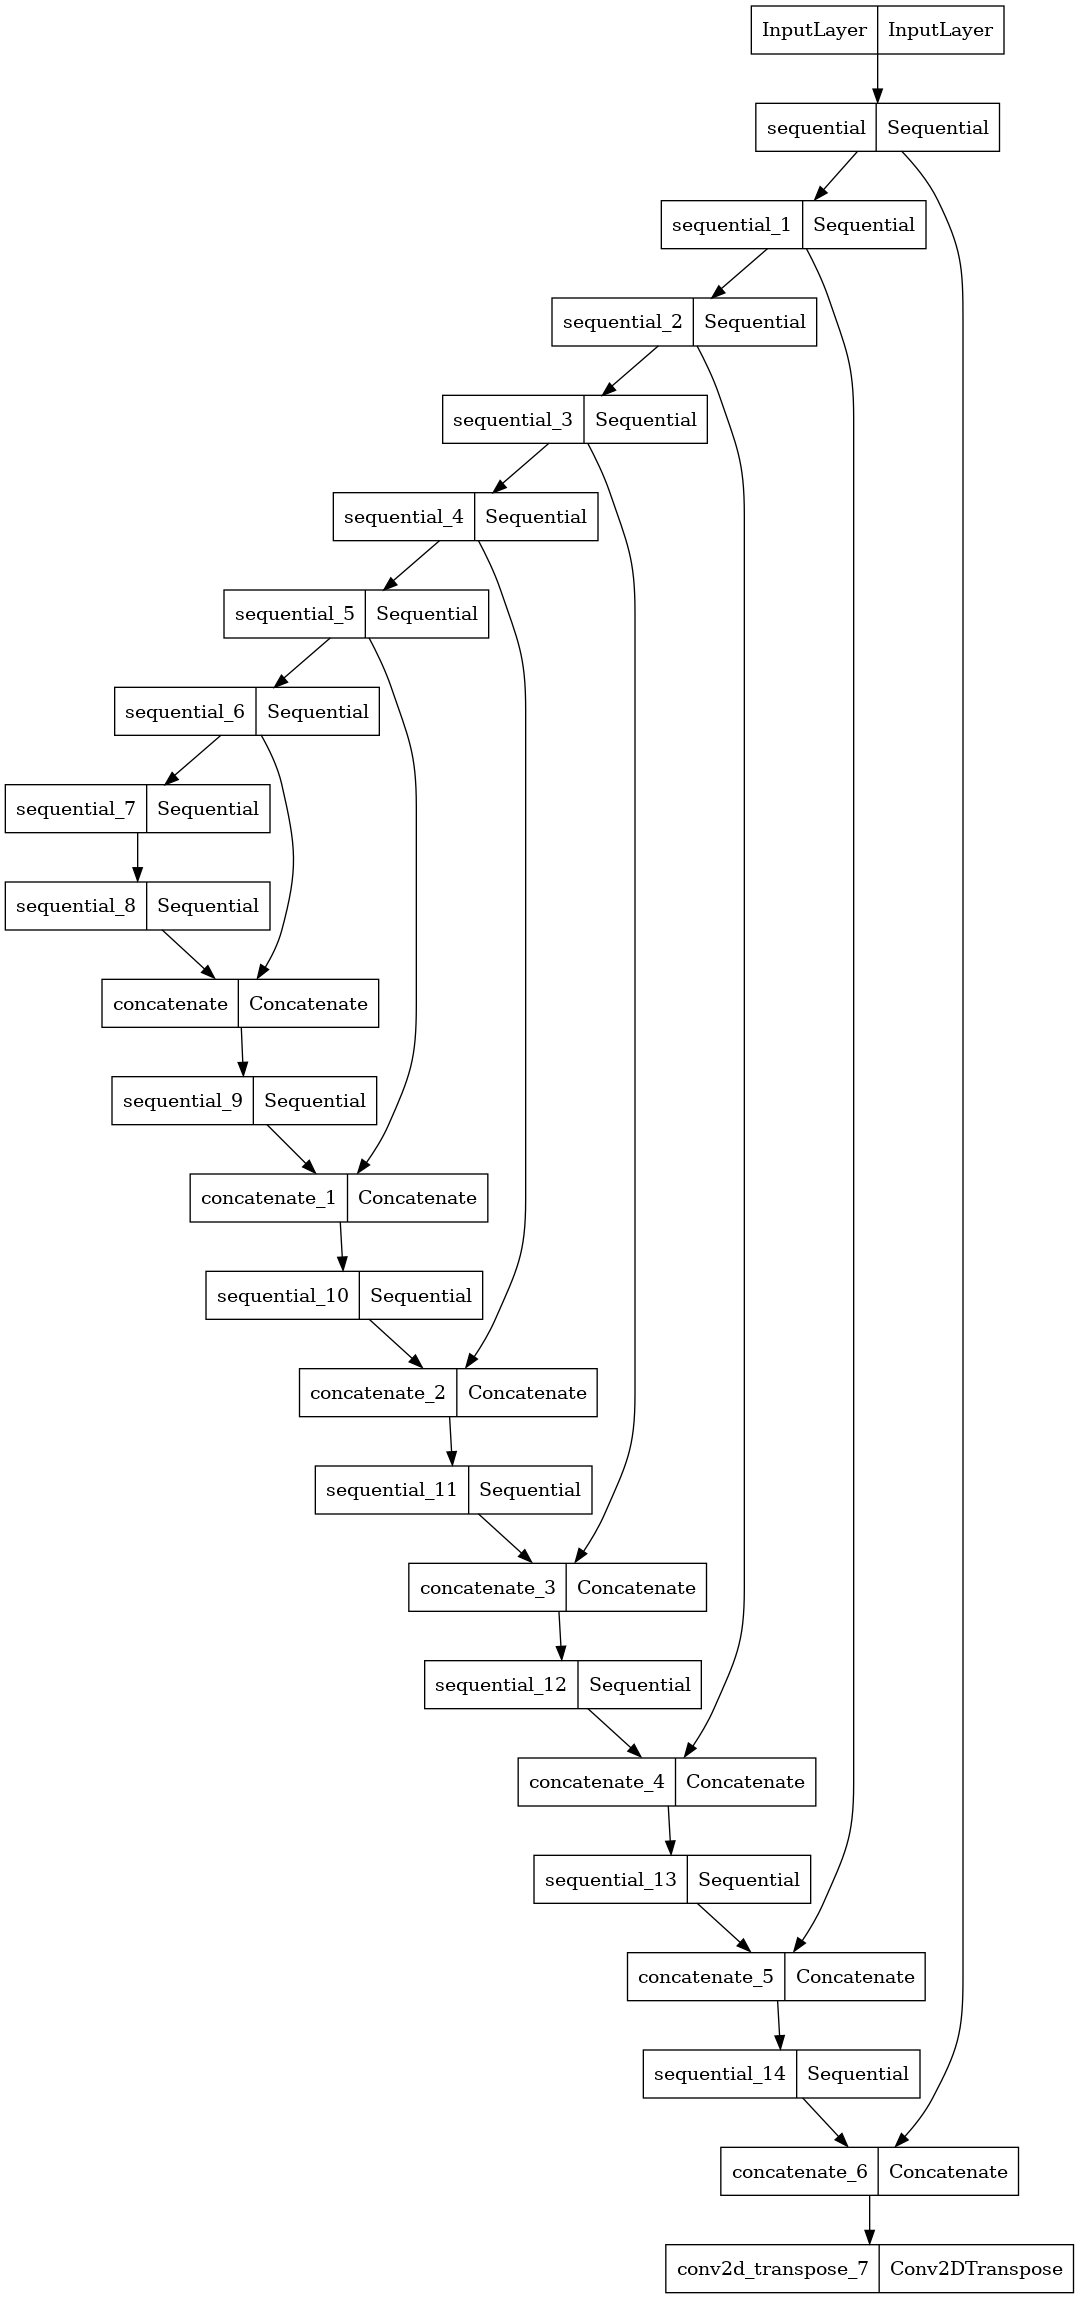

In [5]:
generator = Generator()
plot_model(generator)

### Creating the Discriminator of the model

#### The discrimintor in the Pix2Pix GAN is a Patch Gan

In [6]:
def Discriminator():
    image = Input(shape = (256,256,3), name = "ImageInput")
    target = Input(shape = (256,256,3), name = "TargetInput")
    x = concatenate([image, target])

    x = downscale(64)(x)
    x = downscale(128)(x)
    x = downscale(512)(x)

    initializer = RandomNormal(stddev = 0.02, seed=42)
        
    x = Conv2D(512, kernel_size = 4, strides = 1, kernel_initializer = initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(1, kernel_size = 4, kernel_initializer = initializer)(x)

    discriminator = Model(inputs = [image, target], outputs = x, name = "Discriminator")

    return discriminator

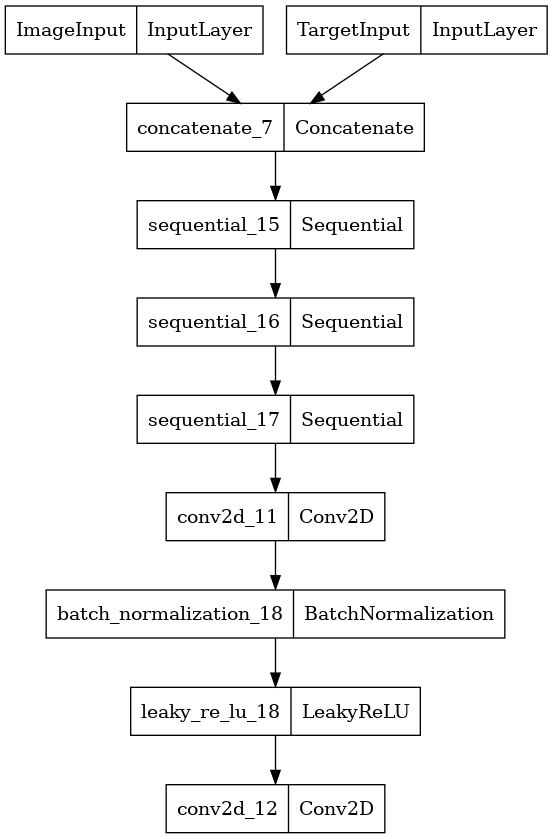

In [7]:
discriminator = Discriminator()
plot_model(discriminator)

## Creating loss functions, and training functions

#### The GAN is a bit different form other DL models, here we just cannot call the model.fit method to start the training process. The loss is passed in a non-sequential fashion here. And to calculate the loss, we make use of the Tensorflow's automatic differentiation engine, that calculates gradients and then we can use the optimizers to perform gradient descent.

In [8]:
adversarial_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

def generator_loss(discriminator_generated, generated_output, target_image):
    gan_loss = adversarial_loss(tf.ones_like(discriminator_generated), discriminator_generated)
    l1_loss = tf.reduce_mean(tf.abs(target_image - generated_output))
    total_loss = (100 * l1_loss) + gan_loss
    return total_loss, gan_loss, l1_loss

def discriminator_loss(discriminator_real_output, discriminator_generated_output):
    real_loss = adversarial_loss(tf.ones_like(discriminator_real_output), discriminator_real_output)
    fake_loss = adversarial_loss(tf.zeros_like(discriminator_generated_output), discriminator_generated_output)
    total_loss = real_loss + fake_loss
    return total_loss

def train_step(inputs, target):
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_output = generator(inputs, training=True)
        
        discriminator_real_output = discriminator([inputs, target], training=True)
        discriminator_generated_output = discriminator([inputs, generated_output], training=True)
        
        generator_total_loss, generator_gan_loss, generator_l1_loss = generator_loss(discriminator_generated_output, generated_output, target)
        
        discriminator_Loss = discriminator_loss(discriminator_real_output, discriminator_generated_output)
        
    generator_gradients = generator_tape.gradient(generator_total_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    discriminator_gradients = discriminator_tape.gradient(discriminator_Loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [9]:
def fit(data, epochs):
  for epoch in range(epochs):
    start = time.time()
    print("Current epoch: ", epoch+1)
    for image, mask in data:
      train_step(image, mask)
    print(f"Time taken to complete the epoch {epoch + 1} is {(time.time() - start):.2f} seconds \n")

In [10]:
sat_image, map_image = tf.cast(images, tf.float32), tf.cast(masks, tf.float32)
dataset = (sat_image,map_image)
data = tf.data.Dataset.from_tensor_slices(dataset).batch(32, drop_remainder=True)

In [11]:
fit(data, 200)

Current epoch:  1
Time taken to complete the epoch 1 is 80.12 seconds 

Current epoch:  2
Time taken to complete the epoch 2 is 57.71 seconds 

Current epoch:  3
Time taken to complete the epoch 3 is 58.67 seconds 

Current epoch:  4
Time taken to complete the epoch 4 is 58.14 seconds 

Current epoch:  5
Time taken to complete the epoch 5 is 58.83 seconds 

Current epoch:  6
Time taken to complete the epoch 6 is 58.95 seconds 

Current epoch:  7
Time taken to complete the epoch 7 is 58.84 seconds 

Current epoch:  8
Time taken to complete the epoch 8 is 58.92 seconds 

Current epoch:  9
Time taken to complete the epoch 9 is 58.91 seconds 

Current epoch:  10
Time taken to complete the epoch 10 is 58.87 seconds 

Current epoch:  11
Time taken to complete the epoch 11 is 58.60 seconds 

Current epoch:  12
Time taken to complete the epoch 12 is 58.27 seconds 

Current epoch:  13
Time taken to complete the epoch 13 is 58.31 seconds 

Current epoch:  14
Time taken to complete the epoch 14 i

In [12]:
def show_predictions(num_samples):
    for i in range(num_samples):
        idx = np.random.randint(images.shape[0])
        image, mask = images[idx], masks[idx]
        predicted = generator.predict(tf.expand_dims(image, axis=0))[0]
        
        plt.figure(figsize=(10,8))
        
        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.title("Satellite Image " + str(i + 1))
        plt.axis('off')
        
        plt.subplot(1,3,2)
        plt.imshow(mask)
        plt.title("Map Image " + str(i + 1))
        plt.axis('off')
        
        plt.subplot(1,3,3)
        plt.imshow(predicted)
        plt.title("Predicted Image " + str(i + 1))
        plt.axis('off')
        
        plt.show()

1/1 [==============================] - 1s 997ms/step


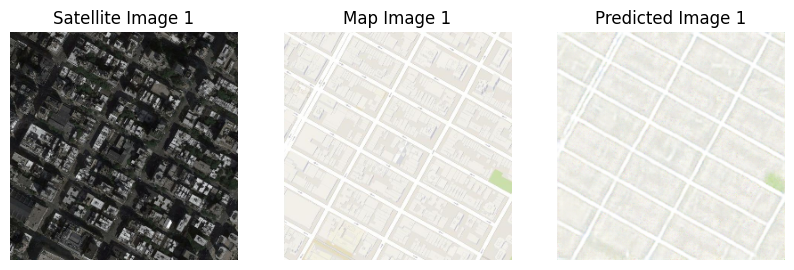

1/1 [==============================] - 0s 21ms/step


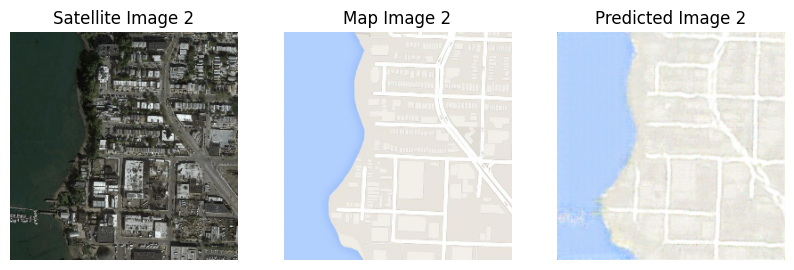

1/1 [==============================] - 0s 22ms/step


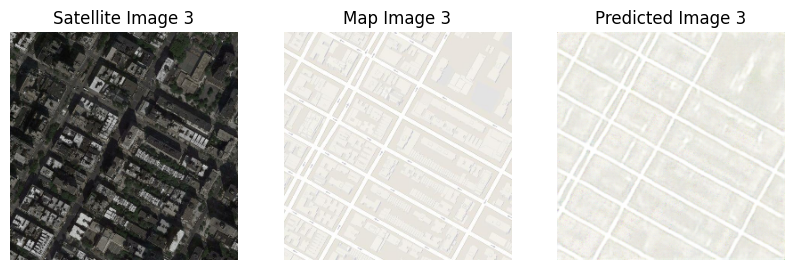

1/1 [==============================] - 0s 21ms/step


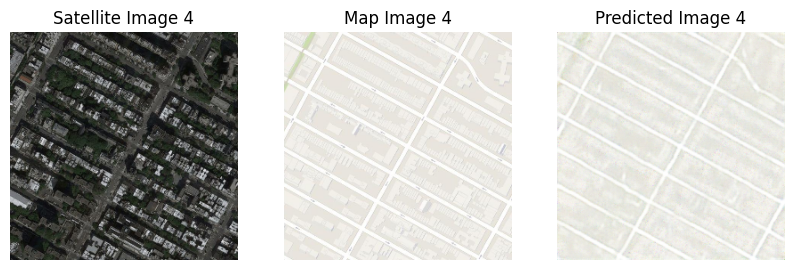

1/1 [==============================] - 0s 20ms/step


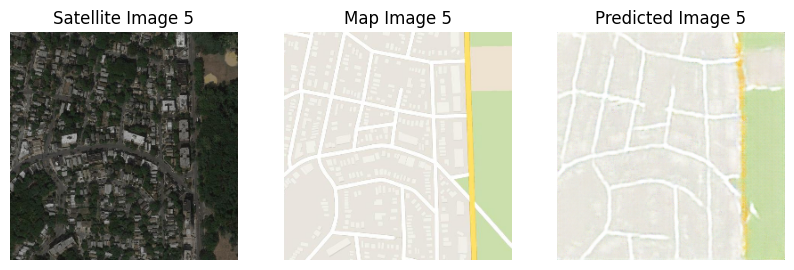

In [13]:
show_predictions(5)

#### The results are decent, one can train the model for more epochs to get better results, and tweak the architecture to get much better results.

In [14]:
generator.save("GAN_Sat_image_2_map.h5")

In [15]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
from scipy.linalg import sqrtm
from sklearn.metrics import pairwise_distances
from tqdm import tqdm

# Load the pre-trained InceptionV3 model from TensorFlow Hub
FID_MODEL = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", pooling="avg")

def preprocess_images(images):
    """Preprocess images to [-1, 1] for InceptionV3."""
    images = (images + 1) * 127.5  # Rescale back to [0, 255]
    return tf.image.resize(images, [299, 299])  # Resize to 299x299 for InceptionV3

def calculate_fid(real_images, generated_images):
    """Calculate Fréchet Inception Distance (FID) between real and generated images."""
    real_images = preprocess_images(real_images)
    generated_images = preprocess_images(generated_images)

    # Get feature embeddings from the InceptionV3 model
    real_embeddings = FID_MODEL.predict(real_images, verbose=0)
    generated_embeddings = FID_MODEL.predict(generated_images, verbose=0)

    # Calculate mean and covariance of real and generated embeddings
    mu_real, sigma_real = np.mean(real_embeddings, axis=0), np.cov(real_embeddings, rowvar=False)
    mu_gen, sigma_gen = np.mean(generated_embeddings, axis=0), np.cov(generated_embeddings, rowvar=False)

    # Compute the Fréchet Distance
    diff = mu_real - mu_gen
    covmean = sqrtm(sigma_real @ sigma_gen)

    # Handle numerical issues with complex results
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid_score = diff @ diff + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid_score

def calculate_inception_score(images, num_splits=10, epsilon=1e-10):
    """Calculate Inception Score (IS) for generated images."""
    images = preprocess_images(images)

    # Get softmax predictions from the InceptionV3 model
    predictions = FID_MODEL.predict(images, verbose=0)
    predictions = tf.nn.softmax(predictions, axis=-1).numpy()

    # Clip predictions to avoid zero probabilities
    predictions = np.clip(predictions, epsilon, 1.0)

    # Split predictions and calculate Inception Score
    split_scores = []
    for i in range(num_splits):
        part = predictions[i * (len(predictions) // num_splits): (i + 1) * (len(predictions) // num_splits)]
        py = np.mean(part, axis=0)
        scores = np.exp(np.mean(np.sum(part * np.log(part / py), axis=1)))
        split_scores.append(scores)

    return np.mean(split_scores), np.std(split_scores)


# Prepare real and generated images
real_images = tf.convert_to_tensor(masks[:100])  # First 100 real map images
generated_images = []

# Generate predicted images for the first 100 satellite images
for i in tqdm(range(100), desc="Generating Predicted Images"):
    predicted_image = generator.predict(tf.expand_dims(images[i], axis=0))[0]
    generated_images.append(predicted_image)

generated_images = tf.convert_to_tensor(generated_images)

# Calculate FID
fid_score = calculate_fid(real_images, generated_images)
print(f"Fréchet Inception Distance (FID): {fid_score:.2f}")

# Calculate Inception Score
is_mean, is_std = calculate_inception_score(generated_images)
print(f"Inception Score (IS): {is_mean:.2f} ± {is_std:.2f}")


87910968/87910968 [==============================] - 0s 0us/step


Generating Predicted Images:   0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:   2%|▏         | 2/100 [00:00<00:07, 13.84it/s]

1/1 [==============================] - 0s 21ms/step


Generating Predicted Images:   4%|▍         | 4/100 [00:00<00:06, 14.14it/s]

1/1 [==============================] - 0s 21ms/step


Generating Predicted Images:   6%|▌         | 6/100 [00:00<00:06, 13.66it/s]

1/1 [==============================] - 0s 21ms/step


Generating Predicted Images:   8%|▊         | 8/100 [00:00<00:06, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


Generating Predicted Images:  10%|█         | 10/100 [00:00<00:06, 13.75it/s]

1/1 [==============================] - 0s 21ms/step


Generating Predicted Images:  12%|█▏        | 12/100 [00:00<00:06, 13.88it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  14%|█▍        | 14/100 [00:01<00:06, 14.06it/s]

1/1 [==============================] - 0s 21ms/step


Generating Predicted Images:  16%|█▌        | 16/100 [00:01<00:06, 13.82it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  18%|█▊        | 18/100 [00:01<00:05, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


Generating Predicted Images:  20%|██        | 20/100 [00:01<00:05, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


Generating Predicted Images:  22%|██▏       | 22/100 [00:01<00:05, 13.96it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  24%|██▍       | 24/100 [00:01<00:05, 14.00it/s]

1/1 [==============================] - 0s 21ms/step


Generating Predicted Images:  26%|██▌       | 26/100 [00:01<00:05, 14.08it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  28%|██▊       | 28/100 [00:02<00:05, 13.99it/s]

1/1 [==============================] - 0s 21ms/step


Generating Predicted Images:  30%|███       | 30/100 [00:02<00:04, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  32%|███▏      | 32/100 [00:02<00:04, 14.16it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  34%|███▍      | 34/100 [00:02<00:04, 14.09it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  36%|███▌      | 36/100 [00:02<00:04, 14.25it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  38%|███▊      | 38/100 [00:02<00:04, 14.08it/s]

1/1 [==============================] - 0s 21ms/step


Generating Predicted Images:  40%|████      | 40/100 [00:02<00:04, 14.17it/s]

1/1 [==============================] - 0s 21ms/step


Generating Predicted Images:  42%|████▏     | 42/100 [00:02<00:04, 14.24it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  44%|████▍     | 44/100 [00:03<00:03, 14.26it/s]

1/1 [==============================] - 0s 22ms/step


Generating Predicted Images:  46%|████▌     | 46/100 [00:03<00:03, 14.09it/s]

1/1 [==============================] - 0s 21ms/step


Generating Predicted Images:  48%|████▊     | 48/100 [00:03<00:03, 14.10it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  50%|█████     | 50/100 [00:03<00:03, 14.20it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  52%|█████▏    | 52/100 [00:03<00:03, 14.29it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  54%|█████▍    | 54/100 [00:03<00:03, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


Generating Predicted Images:  56%|█████▌    | 56/100 [00:03<00:03, 13.99it/s]

1/1 [==============================] - 0s 21ms/step


Generating Predicted Images:  58%|█████▊    | 58/100 [00:04<00:02, 14.10it/s]

1/1 [==============================] - 0s 21ms/step


Generating Predicted Images:  60%|██████    | 60/100 [00:04<00:02, 14.01it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  62%|██████▏   | 62/100 [00:04<00:02, 14.08it/s]

1/1 [==============================] - 0s 21ms/step


Generating Predicted Images:  64%|██████▍   | 64/100 [00:04<00:02, 14.01it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  66%|██████▌   | 66/100 [00:04<00:02, 14.12it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  68%|██████▊   | 68/100 [00:04<00:02, 14.22it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  70%|███████   | 70/100 [00:04<00:02, 14.33it/s]

1/1 [==============================] - 0s 21ms/step


Generating Predicted Images:  72%|███████▏  | 72/100 [00:05<00:01, 14.35it/s]

1/1 [==============================] - 0s 21ms/step


Generating Predicted Images:  74%|███████▍  | 74/100 [00:05<00:01, 14.11it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  76%|███████▌  | 76/100 [00:05<00:01, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  78%|███████▊  | 78/100 [00:05<00:01, 14.28it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  80%|████████  | 80/100 [00:05<00:01, 14.35it/s]

1/1 [==============================] - 0s 21ms/step


Generating Predicted Images:  82%|████████▏ | 82/100 [00:05<00:01, 14.18it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  84%|████████▍ | 84/100 [00:05<00:01, 14.22it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  86%|████████▌ | 86/100 [00:06<00:00, 14.34it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  88%|████████▊ | 88/100 [00:06<00:00, 14.39it/s]

1/1 [==============================] - 0s 20ms/step


Generating Predicted Images:  90%|█████████ | 90/100 [00:06<00:00, 14.44it/s]

1/1 [==============================] - 0s 21ms/step


Generating Predicted Images:  92%|█████████▏| 92/100 [00:06<00:00, 14.05it/s]

1/1 [==============================] - 0s 26ms/step


Generating Predicted Images:  94%|█████████▍| 94/100 [00:06<00:00, 13.85it/s]

1/1 [==============================] - 0s 27ms/step


Generating Predicted Images:  96%|█████████▌| 96/100 [00:06<00:00, 13.70it/s]

1/1 [==============================] - 0s 21ms/step


Generating Predicted Images:  98%|█████████▊| 98/100 [00:06<00:00, 13.35it/s]

1/1 [==============================] - 0s 22ms/step


Generating Predicted Images: 100%|██████████| 100/100 [00:07<00:00, 14.03it/s]


Fréchet Inception Distance (FID): 866.28
Inception Score (IS): 1.00 ± 0.00


In [16]:
def calculate_ssim(real_images, generated_images):
    """Calculate Structural Similarity Index (SSIM) between real and generated images."""
    real_images = preprocess_images(real_images)  # Ensure preprocessing is consistent
    generated_images = preprocess_images(generated_images)

    # Compute SSIM for each pair of real and generated image
    ssim_scores = []
    for real, generated in zip(real_images, generated_images):
        ssim = tf.image.ssim(real, generated, max_val=255)  # Scale is [0, 255] after preprocessing
        ssim_scores.append(ssim.numpy())

    # Calculate mean SSIM
    mean_ssim = np.mean(ssim_scores)
    return mean_ssim
# Calculate SSIM
mean_ssim = calculate_ssim(real_images, generated_images)
print(f"Mean Structural Similarity Index (SSIM): {mean_ssim:.4f}")


Mean Structural Similarity Index (SSIM): 0.9241
